# Introduction

This notebook is for fine-tuning BERT and BERT-like models for sentence pair classification in the PyTorch framework. The original notebook was written to train a Motivational Interviewing reflection filter, which uses a BERT model. This version of the notebook has been tweeked to allow for general purpose BERT fine-tuning.

In this notebook we will create a fresh BERT model with a sequence classification head, first fine-tune it with the Microsoft Research Paraphrase Corpus (MRPC) dataset, and then further fine-tune it with out custom dataset created for our custom task.

The general idea behind this approach is to first allow the BERT model to learn to classify examples of paraphrases, and then further fine-tune it to specialize on a more specific task. If your final task is unrelated to classifying paraphrases, you can use a different set of data to fine-tune your model first (SST, MNLI etc.).

# Installations and Imports

Firstly, We need to install the necessary packages. The most important are `datasets` and `transformers` from HuggingFace. These packages will allow us to do some of the data manipulation and build our BERT model.

In [1]:
!pip install datasets
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 31.4 MB/s 
     |████████████████████████████████| 141 kB 66.4 MB/s 
     |████████████████████████████████| 115 kB 39.0 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 212 kB 70.7 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 127 kB 11.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.1 MB/s 
     |█████████████████████████

Next, we need to import all the necessary modules. The most important ones are the PyTorch related modules, the transformers modules and the datasets modules.

In [2]:
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# torch related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# huggingface related imports
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, \
                        get_cosine_with_hard_restarts_schedule_with_warmup, get_constant_schedule_with_warmup
from datasets import load_dataset, load_metric, concatenate_datasets

The following is just to avoid deadlock warnings when using the Huggingface fast tokenizers.

In [3]:
# avoid deadlock warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load Example GLUE (MRPC) Dataset

Load MRPC dataset for training and testing.

We can use the built-in `load_dataset()` function from HuggingFace to load the MRPC dataset directly. HuggingFace hosts a wide variety of such datasets. You can check out more of their available datasets [here](https://huggingface.co/datasets).

> **Note**: You can skip this step if the model you are using has already been fine-tuned on the MRPC dataset. 
* We should only use the MRPC dataset to fine-tune the model if the base model has not been fine-tuned with MRPC set. In this case, the model will still have to be fine-tuned on our custom data in order to obtain good performance on our custom task.

In [ ]:
# load dataset
ds = load_dataset('glue', 'mrpc')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

We then separate the downloaded dataset into training, validation, and testing sets. In our example, the downloaded MRPC dataset does not contain a testing set, so we use `train_test_split()` to split the original training set into training and testing set.

In [ ]:
# split dataset into train, val, test
train_test_ds = ds['train'].train_test_split(test_size=0.1, seed=1)

train = train_test_ds['train']
test = train_test_ds['test']
val = ds['validation']

df_train = pd.DataFrame(train)
df_val = pd.DataFrame(val)
df_test = pd.DataFrame(test)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-3a93efc30c12b055.arrow and /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-edc310c9ece29aaa.arrow


In [ ]:
df_train.head()

,sentence1,sentence2,label,idx
0,"The American troops , who also defend the mayo...","The American troops from 3-15 infantry , who a...",1,3349
1,"Last week , his lawyers asked Warner to grant ...","Last week , his lawyers asked Gov. Mark R. War...",0,1806
2,Their election increases the board from seven ...,Their appointments increase Berkshire 's board...,1,2681
3,"Dolores Mahoy , 68 , of Colorado Springs , Col...","Dolores E. Mahoy , 68 , of Colorado Springs is...",1,2001
4,""" They were an inspirational couple , selfless...",He said : “ They were an inspirational couple ...,1,2993


# Load Custom Dataset

Load custom dataset for training and testing.

In this notebook, we assume the custom dataset should be a csv file with the following columns:
* **sentence1** - concatenated string of prompt and response
* **sentence2** - string of reflection
* **label** - binary label showing whether sentence2 is an acceptable paraphrase given sentence1

You can tweek this notebook to allow for different custom dataset formats.

In [4]:
# load raw dataset
data_path = '/content/combined_RQC_training_set2.csv'
ds = load_dataset('csv', data_files=data_path, split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-44415d93fc611cfd/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


As good practice, we should fine-tune our model with a balanced dataset. This next step balances our custom dataset based on the number of 0/1 labels. If you do not wish to do this, simply skip this step.

In [5]:
# get all positive and negative examples
positives = ds.filter(lambda x: int(x["label"]) == 1)
negatives = ds.filter(lambda x: int(x["label"]) == 0)

# balance positive and negative examples
if positives.shape[0] > negatives.shape[0]:
  positives = positives.select([x for x in range(negatives.shape[0])])
elif negatives.shape[0] > positives.shape[0]:
  negatives = negatives.select([x for x in range(positives.shape[0])])

ds = concatenate_datasets([positives, negatives])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Shuffle our data.

In [6]:
# shuffle dataset
ds = ds.shuffle(seed=1)

We then separate the balanced dataset into training, validation, and testing sets. Since our custom dataset only has a training set, we first split the training set into 80% training and 20% testing, and then further separate the 20% testing set into 10% testing and 10% validation sets.

After this operation, we should have split the original data into 80% training, 10% validation, and 10% testing sets.

In [7]:
# split dataset into train, val, test
ds = ds.train_test_split(test_size=0.2, shuffle=False)
train = ds['train']
temp = ds['test']
val_test_split = int(len(temp) // 2)
val = temp[:val_test_split]
test = temp[val_test_split:]

df_train = pd.DataFrame(train)
df_val = pd.DataFrame(val)
df_test = pd.DataFrame(test)

print(len(df_train))
print(len(df_val))
print(len(df_test))

582
73
73


In [8]:
df_train.head()

,sentence1,sentence2,label
0,"Prompt: Finally, what are the steps you need t...",Reflection: You realize that if you want to su...,1
1,"Prompt: Now, what is the thing you like least ...",Reflection: You dislike the health effects of ...,1
2,"Prompt: To start, what is the thing you like m...",Reflection: Smoking relieves you of stress and...,1
3,Prompt: What will it look like when you have m...,Reflection: You see that smoking is expensive ...,1
4,"Prompt: Now, what is the thing you like least ...",Reflection: You find that people are uncomfort...,0


# Classes and Functions

Next, we need to implement a custom dataset class that wraps our data with the tokenizer. This class inherits from PyTorch `Dataset` class with overloaded `__len__()` and `__getitem__()` function, which allows it to be passed as a Dataset object into the PyTorch `Dataloader()` function to create a dataloader. The input data is tokenized in the constructor of this class.

Later, we will create `CustomTextDataset` objects for each of our training set, validation set and testing set. The data will be automatically tokenized in the process and then passed into `Dataloader()` to create a tokenized dataloader ready to be used for training.

> Note: Creating a custom dataset class that inherits from PyTorch `Dataset` class and then passing it to `Dataloader()` to create tokenized dataloader is a very common practice. In this process, we must create overloaded `__len__()` and `__getitem__()` functions which will be used during training. For more information on this pattern see [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class).

In [9]:
class CustomTextDataset(Dataset):

  def __init__(self, dataset_name, dataset, max_len, with_label=True, model='bert-base-uncased'):

    # initialize parameters
    self.dataset_name = dataset_name
    self.dataset = dataset
    self.max_len = max_len
    self.with_label = with_label
    self.tokenizer = AutoTokenizer.from_pretrained(model)
    self.input_ids = []
    self.attention_mask = []
    self.token_type_ids = []
    self.labels = []

    # tokenize dataset
    for index in range(len(self.dataset)):
      s1 = str(self.dataset.loc[index, 'sentence1'])
      s2 = str(self.dataset.loc[index, 'sentence2'])

      tokenized = self.tokenizer(
        s1,
        s2,
        padding='max_length',
        max_length=self.max_len,
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=True,
        return_attention_mask=True
      )

      # store tokenized data into input_ids, attention_mask, token_type_ids
      self.input_ids.append(tokenized['input_ids'].squeeze(0))
      self.attention_mask.append(tokenized['attention_mask'].squeeze(0))
      self.token_type_ids.append(tokenized['token_type_ids'].squeeze(0))

      if self.with_label:
        self.labels.append(self.dataset.loc[index, 'label'])


  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, index):
    if self.with_label:
      return self.input_ids[index], self.attention_mask[index], self.token_type_ids[index], self.labels[index]

    return self.input_ids[index], self.attention_mask[index], self.token_type_ids[index]

Perhaps one of the most important setup step is to create a model class for our BERT model. The following `Model` class inherits from PyTorch `nn.Module` and implements our entire model.

Our model consists of 2 main components - the transformer (BERT) layers and the classification head. HuggingFace hosts many pretrained versions of BERT and BERT-based models, so we can simply download the BERT layers straight from HuggingFace Hub by using their built-in `from_pretrained()` function. For detailed information on how to use HuggingFace models see [here](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel).

There might be cases where freezing the transformer portion of the model and only fine-tuning the classification head is more helpful. For this we have an option to disable all parameters in the transformer from updating during training.

We must also implement the overloaded `forward()` function, which handles model inference. The `autocast()` decorator enables running model inference in mixed precision, which can make training more efficient.

> Note: Creating a custom model class that inherits from PyTorch `nn.Module` class is a very common practice. In this process, we must create overloaded `forward()` function which will be used during training, evaluation and testing. For more information on this pattern see [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

In [10]:
# mapping between model name and hidden size
model_to_hidden_size = {
    "bert-base-uncased": 768,
    "bert-base-cased-finetuned-mrpc": 768,
    "microsoft/deberta-base": 768,
    "textattack/roberta-base-MRPC": 768,
    "textattack/albert-base-v2-MRPC": 768,
    "textattack/distilbert-base-cased-MRPC": 768,
}

class Model(nn.Module):

  def __init__(self, model="bert-base-cased-finetuned-mrpc", freeze_transformer=False):
    super(Model, self).__init__()

    # get appropriate hidden size
    if model in model_to_hidden_size:
      hidden_size = model_to_hidden_size[model]
    else:
      hidden_size = 768

    self.model_name = model

    # initialize model layers
    self.transformer = AutoModel.from_pretrained(model)
    self.classification_head = nn.Linear(hidden_size, 1)
    self.dropout = nn.Dropout(p=0.1)

    # freeze all parameters in transformer portion of the model
    if freeze_transformer:
      for p in self.transformer.parameters():
        p.requires_grad = False

  # execute in mixed precision
  @autocast()
  def forward(self, input_ids, attention_mask, token_type_ids):
    transformer_out = self.transformer(input_ids, attention_mask, token_type_ids)
    out = transformer_out.pooler_output
    out = self.dropout(out)
    logits = self.classification_head(out)

    return logits

The following functions are used to evaluate the model using the validation dataset. The predict function is also called during testing.

In essence, the predict function performs model inference on the dataloader passed in, which is `val_loader` when evaluating and `test_loader` when testing.

In [11]:
def predict(model, device, dataloader, criterion=None, mode="eval", with_label=True):

  # switch to eval mode
  model.eval()
  probabilities = []
  loss_sum, count = 0, 0

  # get examples from dataloader and use model to predict probabilities
  if mode == "test":
    with torch.no_grad():
      if with_label:
        for input_ids, attention_mask, token_type_ids, _ in tqdm(dataloader):
          input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
          logits = model(input_ids, attention_mask, token_type_ids)
          prob = torch.sigmoid(logits).detach().cpu().numpy().squeeze(-1)
          probabilities += prob.tolist()
      else:
        for input_ids, attention_mask, token_type_ids in tqdm(dataloader):
          input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
          logits = model(input_ids, attention_mask, token_type_ids)
          prob = torch.sigmoid(logits).detach().cpu().numpy().squeeze(-1)
          probabilities += prob.tolist()
  elif mode == "eval":
    with torch.no_grad():
      for input_ids, attention_mask, token_type_ids, labels in tqdm(dataloader):
        input_ids, attention_mask, token_type_ids, labels = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), labels.to(device)
        logits = model(input_ids, attention_mask, token_type_ids)
        prob = torch.sigmoid(logits).detach().cpu().numpy().squeeze(-1)
        probabilities += prob.tolist()
        loss_sum += criterion(logits.squeeze(-1), labels.float()).item()
        count += 1
  
  # switch to train mode
  model.train()
  if mode == "test":
    return probabilities
  return loss_sum / count, probabilities

def evaluate(model, device, criterion, dataloader):

  # get predictions from model
  mean_loss, probabilities = predict(model, device, dataloader, criterion=criterion, mode="eval", with_label=True)

  threshold = 0.5
  preds = []

  # convert probabilities to labels
  for prob in probabilities:
    preds.append(1 if prob >= threshold else 0)
  
  # calculate accuracy
  metric = load_metric("accuracy")
  accuracies = metric.compute(predictions=preds, references=dataloader.dataset.dataset["label"])

  return mean_loss, accuracies["accuracy"]

the following function is used to set all seeds to make results reproducible.

In [12]:
def set_seeds(seed):

  # PyTorch random number generator seeds
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  # force determinism in torch cuda
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  # other sources of randomness
  np.random.seed(seed)
  random.seed(seed)

# Trainer Function

Main trainer function.

notice that `GradScaler()` is used. This function is used to scale the loss before performing back propagation to avoid vanishing gradients. For more information on this see [here](https://pytorch.org/docs/stable/amp.html).

In [13]:
def train(model, criterion, optimizer, lr, lr_scheduler, train_loader, val_loader, epochs, 
          prints_per_epoch, evals_per_epoch):
  
  best_loss = np.Inf
  best_ep = 1
  best_it = 1
  total_it = len(train_loader)
  print_every = total_it // prints_per_epoch if prints_per_epoch else 0
  eval_every = total_it // evals_per_epoch if evals_per_epoch else 0

  # for plotting
  iters = []
  val_iters = []
  train_losses = []
  val_losses = []
  val_accs = []

  scaler = GradScaler()

  for ep in range(epochs):

    model.train()
    running_loss = 0.0

    print("Starting epoch {} of {}...".format(ep + 1, epochs))
    for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(train_loader)):

      seq, attn_masks, token_type_ids, labels = seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)

      # run in mixed precision for model inference and loss calculation
      with autocast():
        logits = model(seq, attn_masks, token_type_ids)
        loss = criterion(logits.squeeze(-1), labels.float())

      # scale the loss to avoid vanishing gradients, and then perform backward propagation
      scaler.scale(loss).backward()
      # first unscales the gradient and calls optimizer.step()
      scaler.step(optimizer)
      # updates the scale for next iteration
      scaler.update()
      # updates the learning rate for the next iteration
      lr_scheduler.step()
      # clears gradients
      optimizer.zero_grad()

      running_loss += loss.item()

      if iters:
        iters.append(iters[-1] + 1)
      else:
        iters.append(0)
      train_losses.append(float(loss))

      # print training progress
      if print_every and (it + 1) % print_every == 0:
        print()
        print("Iteration {}/{} of epoch {} complete. train_loss : {} ".format(it + 1, total_it, ep + 1, running_loss / print_every))
        running_loss = 0.0
      
      # perform evaluation and print results
      if eval_every and (it + 1) % eval_every == 0:
        val_loss, val_acc = evaluate(model, device, criterion, val_loader)
        val_iters.append(iters[-1])
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print("=" * 70)
        print("Eval results - Iteration {}/{} of epoch {}: val_loss: {}, val_acc: {}"
              .format(it + 1, total_it, ep + 1, round(val_loss, 2), round(val_acc, 2)))

        if val_loss < best_loss:
          print("Best val loss improved from {} to {}".format(best_loss, val_loss))
          print("Saving a copy of the model...")
          net_copy = copy.deepcopy(model)
          best_loss = val_loss
          best_ep = ep + 1
          best_it = it + 1
        print("=" * 70 + "\n")

    # perform evaluation and print results
    if eval_every == 0:
      val_loss, val_acc = evaluate(model, device, criterion, val_loader)
      val_iters.append(iters[-1])
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      print("=" * 70)
      print("Eval results - epoch {}: val_loss: {}, val_acc: {}".format(ep+1, round(val_loss, 2), round(val_acc, 2)))

      if val_loss < best_loss:
        print("Best val loss improved from {} to {}".format(best_loss, val_loss))
        print("Saving a copy of the model...")
        net_copy = copy.deepcopy(model)
        best_loss = val_loss
        best_ep = ep + 1
        best_it = it + 1
      print("=" * 70 + "\n")

  # save best model
  path_to_model='models/{}_{}_lr_{}_val_loss_{}_ep_{}_it_{}.pt'\
        .format(model_name.replace('/', '-'), train_loader.dataset.dataset_name, lr, round(best_loss, 5), best_ep, best_it)
  torch.save(net_copy.state_dict(), path_to_model)
  print("The best model has been saved in {}".format(path_to_model))

  # plot loss and accuracy curves
  print("\nplots:")
  plt.title("loss curve")
  plt.plot(iters, train_losses)
  plt.plot(val_iters, val_losses)
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.show()

  plt.title("val accuracy curve")
  plt.plot(val_iters, val_accs)
  plt.xlabel("iterations")
  plt.ylabel("accuracy")
  plt.show()

  del loss
  torch.cuda.empty_cache()

# Finetuning

Now we are ready to do some fine-tunng! 

The following cell contains all training parameters including base model used, hyperparameters and others. Feel free to experiment with your own settings.

In [14]:
# model settings
model_name = "bert-base-cased-finetuned-mrpc"
dataset_name = "combined_RQC_training_set2.csv"
use_pretrained = False          # enabling this will load the weights stored in pretrained_path
pretrained_path = '/content/bert-base-cased-finetuned-mrpc_MIV4.0-4.4_lr_3e-06_val_loss_0.47839_ep_14_it_29.pt'
freeze_transformer = False
maxlen = 128

# hyperparameters
bs = 8
lr = 3e-6
weight_decay = 1e-2
epochs = 12
evals_per_epoch = 2

# lr_scheduler settings
lr_scheduler_type = "linear"    # must be one of the 3: "constant", "linear", or "cosine"
num_warmup_steps = 0
num_cycles = 2                  # only for "cosine" lr_scheduler

#printing settings
prints_per_epoch = 4

# set all seeds to ensure reproducible results
set_seeds(1)

In [15]:
!mkdir models

Create train and validation dataloaders

In [16]:
# create training and validation set
print("creating datasets...")
train_set = CustomTextDataset(dataset_name, df_train, maxlen, model=model_name)
val_set = CustomTextDataset(dataset_name, df_val, maxlen, model=model_name)

# create training and validation dataloaders
print("creating dataloaders...")
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)
val_loader = DataLoader(val_set, batch_size=bs, num_workers=2)

creating datasets...


creating dataloaders...


Create RQC model and optionally load pretrained weights and move the model to device

In [17]:
# create model
print("creating a fresh model...")
model = Model(model_name, freeze_transformer=freeze_transformer)

# check if we can train on GPU
device = None
if torch.cuda.is_available():
  print("GPU available")
  device = torch.device("cuda:0")
else:
  print("GPU unavailable, using CPU")
  device = torch.device("cpu")

# load pretrained model weights if using a pretrained model
if use_pretrained:
  print("loading pretrained model weights...")
  model.load_state_dict(torch.load(pretrained_path))

# check if we can use multiple GPUs
if torch.cuda.device_count() > 1:
  print("multiple GPUs available")
  print("using ", torch.cuda.device_count(), " GPUs")
  model = nn.DataParallel(model)

model.to(device)

creating a fresh model...


Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPU available


Model(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

Set criterion, optimizers and lr_schedular for training

In [18]:
# intialize criterion, optimizer, and lr_scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = epochs * len(train_loader)

# get learning rate scheduler
lr_scheduler = get_constant_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps)
if lr_scheduler_type == "constant":
  lr_scheduler = get_constant_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps)
if lr_scheduler_type == "linear":
  lr_scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
if lr_scheduler_type == "cosine":
  lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=num_cycles)

Train the model

Starting epoch 1 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 1 complete. train_loss : 0.6982811590035757 

Iteration 36/73 of epoch 1 complete. train_loss : 0.6841466724872589 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 1: val_loss: 0.67, val_acc: 0.71
Best val loss improved from inf to 0.6693750381469726
Saving a copy of the model...


Iteration 54/73 of epoch 1 complete. train_loss : 0.6605300737751855 

Iteration 72/73 of epoch 1 complete. train_loss : 0.6702429287963443 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 1: val_loss: 0.66, val_acc: 0.74
Best val loss improved from 0.6693750381469726 to 0.6566365242004395
Saving a copy of the model...

Starting epoch 2 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 2 complete. train_loss : 0.665808939271503 

Iteration 36/73 of epoch 2 complete. train_loss : 0.6507879429393344 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 2: val_loss: 0.64, val_acc: 0.68
Best val loss improved from 0.6566365242004395 to 0.6416029930114746
Saving a copy of the model...


Iteration 54/73 of epoch 2 complete. train_loss : 0.6356494194931455 

Iteration 72/73 of epoch 2 complete. train_loss : 0.6385851932896508 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 2: val_loss: 0.65, val_acc: 0.7

Starting epoch 3 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 3 complete. train_loss : 0.6608965628676944 

Iteration 36/73 of epoch 3 complete. train_loss : 0.6017000840769874 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 3: val_loss: 0.62, val_acc: 0.75
Best val loss improved from 0.6416029930114746 to 0.6186658859252929
Saving a copy of the model...


Iteration 54/73 of epoch 3 complete. train_loss : 0.5904673172367944 

Iteration 72/73 of epoch 3 complete. train_loss : 0.591294676065445 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 3: val_loss: 0.62, val_acc: 0.71
Best val loss improved from 0.6186658859252929 to 0.6154243469238281
Saving a copy of the model...

Starting epoch 4 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 4 complete. train_loss : 0.6215041610929701 

Iteration 36/73 of epoch 4 complete. train_loss : 0.5675573845704397 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 4: val_loss: 0.59, val_acc: 0.73
Best val loss improved from 0.6154243469238281 to 0.5858123779296875
Saving a copy of the model...


Iteration 54/73 of epoch 4 complete. train_loss : 0.5562908434205585 

Iteration 72/73 of epoch 4 complete. train_loss : 0.5643369290563796 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 4: val_loss: 0.6, val_acc: 0.74

Starting epoch 5 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 5 complete. train_loss : 0.5904032124413384 

Iteration 36/73 of epoch 5 complete. train_loss : 0.5279257347186407 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 5: val_loss: 0.57, val_acc: 0.74
Best val loss improved from 0.5858123779296875 to 0.567286491394043
Saving a copy of the model...


Iteration 54/73 of epoch 5 complete. train_loss : 0.5402542120880551 

Iteration 72/73 of epoch 5 complete. train_loss : 0.5137502319282956 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 5: val_loss: 0.56, val_acc: 0.75
Best val loss improved from 0.567286491394043 to 0.5637256622314453
Saving a copy of the model...

Starting epoch 6 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 6 complete. train_loss : 0.5748791777425342 

Iteration 36/73 of epoch 6 complete. train_loss : 0.5128726644648446 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 6: val_loss: 0.56, val_acc: 0.75
Best val loss improved from 0.5637256622314453 to 0.5630020141601563
Saving a copy of the model...


Iteration 54/73 of epoch 6 complete. train_loss : 0.49491185115443337 

Iteration 72/73 of epoch 6 complete. train_loss : 0.49679716924826306 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 6: val_loss: 0.56, val_acc: 0.75
Best val loss improved from 0.5630020141601563 to 0.5610595703125
Saving a copy of the model...

Starting epoch 7 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 7 complete. train_loss : 0.5364111314217249 

Iteration 36/73 of epoch 7 complete. train_loss : 0.4678111688958274 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 7: val_loss: 0.55, val_acc: 0.75
Best val loss improved from 0.5610595703125 to 0.5502853393554688
Saving a copy of the model...


Iteration 54/73 of epoch 7 complete. train_loss : 0.4813975393772125 

Iteration 72/73 of epoch 7 complete. train_loss : 0.46328004863527084 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 7: val_loss: 0.56, val_acc: 0.74

Starting epoch 8 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 8 complete. train_loss : 0.5203799340460036 

Iteration 36/73 of epoch 8 complete. train_loss : 0.43675315545664894 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 8: val_loss: 0.55, val_acc: 0.74


Iteration 54/73 of epoch 8 complete. train_loss : 0.4377283602952957 

Iteration 72/73 of epoch 8 complete. train_loss : 0.4329331898026996 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 8: val_loss: 0.56, val_acc: 0.75

Starting epoch 9 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 9 complete. train_loss : 0.5012738588783476 

Iteration 36/73 of epoch 9 complete. train_loss : 0.39180978056457305 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 9: val_loss: 0.55, val_acc: 0.77


Iteration 54/73 of epoch 9 complete. train_loss : 0.4158235672447417 

Iteration 72/73 of epoch 9 complete. train_loss : 0.42084955010149216 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 9: val_loss: 0.54, val_acc: 0.75
Best val loss improved from 0.5502853393554688 to 0.5396064758300781
Saving a copy of the model...

Starting epoch 10 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 10 complete. train_loss : 0.4688177638583713 

Iteration 36/73 of epoch 10 complete. train_loss : 0.40343234688043594 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 10: val_loss: 0.55, val_acc: 0.75


Iteration 54/73 of epoch 10 complete. train_loss : 0.3828419910536872 

Iteration 72/73 of epoch 10 complete. train_loss : 0.4137665894296434 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 10: val_loss: 0.54, val_acc: 0.75

Starting epoch 11 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 11 complete. train_loss : 0.45626547435919446 

Iteration 36/73 of epoch 11 complete. train_loss : 0.36163590765661663 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 11: val_loss: 0.55, val_acc: 0.75


Iteration 54/73 of epoch 11 complete. train_loss : 0.38603929926951724 

Iteration 72/73 of epoch 11 complete. train_loss : 0.3836301921142472 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 11: val_loss: 0.55, val_acc: 0.75

Starting epoch 12 of 12...


  0%|          | 0/73 [00:00<?, ?it/s]


Iteration 18/73 of epoch 12 complete. train_loss : 0.4614604421787792 

Iteration 36/73 of epoch 12 complete. train_loss : 0.3623628367980321 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 36/73 of epoch 12: val_loss: 0.55, val_acc: 0.75


Iteration 54/73 of epoch 12 complete. train_loss : 0.37863589657677543 

Iteration 72/73 of epoch 12 complete. train_loss : 0.4000568820370568 


  0%|          | 0/10 [00:00<?, ?it/s]

Eval results - Iteration 72/73 of epoch 12: val_loss: 0.55, val_acc: 0.75

The best model has been saved in models/bert-base-cased-finetuned-mrpc_combined_RQC_training_set2.csv_lr_3e-06_val_loss_0.53961_ep_9_it_72.pt

plots:


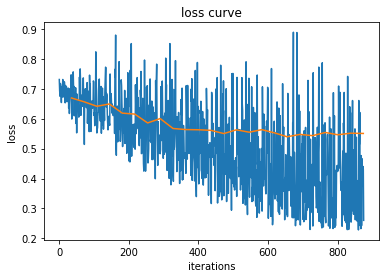

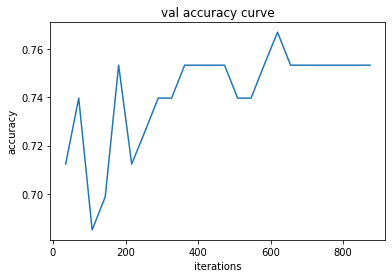

In [19]:
train(model, criterion, optimizer, lr, lr_scheduler, train_loader, val_loader, epochs, prints_per_epoch, evals_per_epoch)

# Load Custom Testing Dataset

Load custom testing dataset from a csv file

**IMPORTANT**: skip this step if you want to use the test set created when loading your custom dataset

In [ ]:
data_path = '/content/RQC_comparison_set2.csv'
test_ds = load_dataset('csv', data_files=data_path, split="train")

print(test_ds.shape)

df_test = pd.DataFrame(test_ds)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3bd4d5636c530e71/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.
(1, 2)


# Testing

In [20]:
!mkdir results

This function is similar to the evaluate function. It calls `predict()` function and writes the generated probabilities into file.

In [21]:
def test(model, device, dataloader, result_file="results/output.txt", with_label=True):
  # get predictions from model
  probabilities = predict(model, device, dataloader, mode="test", with_label=with_label)

  # write probability results to results file
  output_file = open(result_file, 'w')
  output_file.writelines(str(prob)+'\n' for prob in probabilities)
  output_file.close()

Settings for testing the model.

The threshold value can be tweeked to achieve the desired results. For guidance on what threshold values to use, see [ROC_curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

In [22]:
model_path = '/content/models/bert-base-cased-finetuned-mrpc_combined_RQC_training_set2.csv_lr_3e-06_val_loss_0.53961_ep_9_it_72.pt'
output_path = 'results/probs.txt'
threshold = 0.5

We first create the test dataloader and a fresh new model. We then load the pretrained weights into the model and test it against the test dataset.

The testing results are a list of probabilities and are stored in the specified output file.

In [23]:
print("creating test dataset and dataloader...")
test_set = CustomTextDataset(dataset_name, df_test, maxlen, with_label=False, model=model_name)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=2)

print("creating a model...")
model = Model(model_name)

print("loading pretrained model weights...")
model.load_state_dict(torch.load(model_path))

# check if we can train on GPU
device = None
if torch.cuda.is_available():
  print("GPU available")
  device = torch.device("cuda:0")
else:
  print("GPU unavailable, using CPU")
  device = torch.device("cpu")

# check if we can use multiple GPUs
if torch.cuda.device_count() > 1:
  print("multiple GPUs available")
  print("using ", torch.cuda.device_count(), " GPUs")
  model = nn.DataParallel(model)

model.to(device)

print("testing...")
test(model=model, device=device, dataloader=test_loader, result_file=output_path, with_label=False)
print("result probabilities are available in: {}".format(output_path))

creating test dataset and dataloader...
creating a model...


Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


loading pretrained model weights...
GPU available
testing...


  0%|          | 0/10 [00:00<?, ?it/s]

result probabilities are available in: results/probs.txt


Convert probability values in probs.txt to binary labels based on the chosen threshold.

In [24]:
output_path = 'results/probs.txt'
probs = pd.read_csv(output_path, header=None)[0]

# convert probabilities to binary labels
preds=(probs>=threshold).astype('uint8')
print(len(preds))

73


Save results to a csv file.

In [26]:
# save binary label results
path_to_save_file = '/content/out.csv'

out_df = pd.DataFrame(columns=['sentence1','sentence2','RQC_label'])
out_df['sentence1'] = df_test['sentence1']
out_df['sentence2'] = df_test['sentence2']
out_df['RQC_label'] = preds

out_df.to_csv(path_to_save_file, index=False)

Run accuracy metrics on model predictions

**IMPORTANT**: only run this if the testing dataset contains labels

In [25]:
labels_test = df_test['label']
metric = load_metric("accuracy")

# compute accuracy
metric._compute(predictions=preds, references=labels_test)

{'accuracy': 0.6164383561643836}